# Promoter Test 2 - pLac

In this experiment, we have tried three different candidate promoters: Arabinose, Lac (via IPTG) annd Rhamnose

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../../')
import BrasilUSP_iGEM_LabLib as LabLib

import scipy.stats
import pylab as pl
import numpy as np
import glob
from math import sqrt



## Definitions...

def biolrepl(wells):
    return np.array( [ wells[0:3].mean(), wells[3:6].mean(), wells[6:9].mean() ] ), \
        np.array( [ np.std(wells[0:3]), np.std(wells[3:6]), np.std(wells[6:9]) ] )

ColumnNames = {
    'A' : "-control",
    'B' : "+control",
    'C' : "ZeroC",
    'D' : "C1",
    'E' : "C2",
    'F' : "C3",
    'G' : "C4",
    'H' : "C5"
}

Pidxs = ['Lac']
Pcolors = {'Rha' : (1.0,0.5,0.3), 'Lac' : (0.3,0.5,1.0)}
Pcolors_light = {'Rha' : (1.0,0.8,0.6), 'Lac' : (0.6,0.8,1.0)}


MeaningColNames = {v : k for k, v in ColumnNames.items()}


def allCols(labels, r0 = 1, rf = 9):
    if type(labels) != list: 
        labels = [labels]
    cols = []
    for label in labels:
        row  = MeaningColNames[label]
        for j in range(r0,rf+1):
            cols.append(row + '0' + str(j))
    return cols

### Reading measurements

In [2]:
FLlist = {}
tidx = {}
for P in Pidxs: 
    FLlist[P] = []
    tidx[P] = []

for P in Pidxs:
    for file in glob.glob("fluorescencia/t2 p"+P+"/*.txt"):
        tidx[P].append( float( file.split(' ')[3].split('.')[0] ) )
        FLlist[P].append(file)

for P in Pidxs: 
    Idx = np.argsort(tidx[P])
    FLlist[P] = np.array(FLlist[P])[Idx]

Let now read the data. In this experiment, we have recordings from two different wavelengths, regarding Gfp and Rfp proteins. Let's start reading GFP.

In [3]:
fldata = {}
for P in Pidxs:
    fldata[P] = LabLib.ReadFluor_timefmt_nanomed(FLlist[P])
fldata['Lac'][allCols('-control')].head(3)

,A01,A02,A03,A04,A05,A06,A07,A08,A09
0,962.584,789.014,933.612,752.784,803.358,788.130,833.105,944.651,951.532
1,1189.126,837.693,953.412,767.151,806.102,807.975,878.832,944.655,998.237
2,1076.447,847.734,851.675,733.675,733.392,803.632,795.051,850.047,917.630


Since we have three different plates, one for each promoter, let's quickly check the temperature in each plate separately.

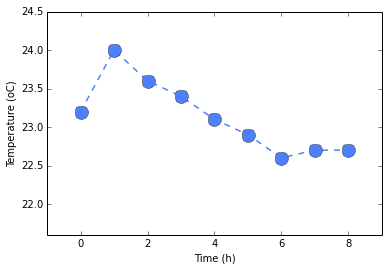

In [5]:
for P in Pidxs:
    pl.plot(fldata[P]['T(oC)'], 'o--', lw=1.5, markersize=13., color=Pcolors[P], markeredgecolor=(0.2,0.2,0.2))

pl.xlabel('Time (h)')
pl.xlim(-1,9)
pl.ylabel('Temperature (oC)')
pl.ylim(21.6,24.5)
pl.legend(bbox_to_anchor=(0.9, 0.4))
pl.show()

Temperature seems quite reasonable accross different boards.

### OD measurements

In [6]:
oddata = {}
for P in Pidxs:
    ODlist = []
    for j in range(10):
        ODlist.append("OD/od p"+P+" teste 1/OD "+str(j)+" p"+P+" t1.txt")
    
    oddata[P] = LabLib.ReadFluor_timefmt_nanomed(ODlist, nr_header=2)

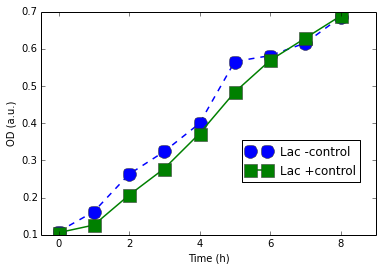

In [7]:
for P in Pidxs:
    pl.plot(np.mean(np.array(oddata[P][allCols('-control')]), axis=1), 
            'o--', lw=1.5, markersize=13., markeredgecolor=(0.2,0.2,0.2), label=P+" -control")
for P in Pidxs:
    pl.plot(np.mean(np.array(oddata[P][allCols('+control')]), axis=1), 
            's-', lw=1.5, markersize=13., markeredgecolor=(0.2,0.2,0.2), label=P+" +control")

pl.xlabel('Time (h)')
pl.xlim(-0.5,9.)
pl.ylabel('OD (a.u.)')
pl.legend(bbox_to_anchor=(0.97, 0.45))
pl.show()
pl.show()

### Baselines: +control and NoPlasmid

Baseline for Lac:	   919 a.u.


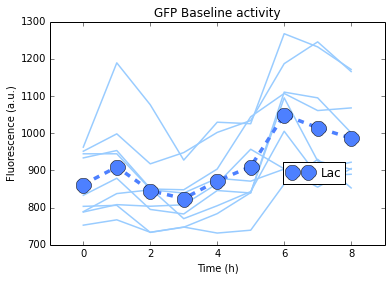

In [8]:
for P in Pidxs:
    pl.plot(fldata[P][allCols('-control')], color=Pcolors_light[P], lw=1.5)

for P in Pidxs:
    pl.plot(np.mean(np.array( fldata[P][allCols('-control')] ), axis=1), 
            'o--', color=Pcolors[P], lw=3.5, markersize=15, label=P)
    
    print "Baseline for " + P + ":\t %5.0f a.u." % \
    (np.mean(np.array( fldata[P][allCols('-control')] ), axis=1).mean())


pl.title('GFP Baseline activity')
pl.xlabel('Time (h)')
pl.xlim(-1,9)
pl.ylabel('Fluorescence (a.u.)')
pl.legend(bbox_to_anchor=(0.9, 0.4))
pl.show()

Gfp baseline activity seems to be around 900 a.u. for all three plates.

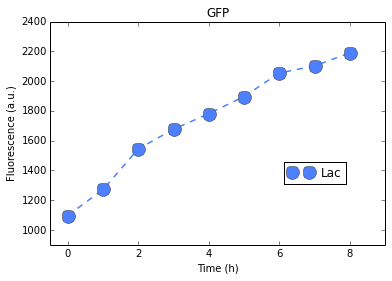

In [9]:
for P in Pidxs:
    pl.plot(np.mean(np.array( fldata[P][allCols('+control')] ), axis=1), 
            'o--', lw=1.5, markersize=13., color=Pcolors[P], markeredgecolor=(0.2,0.2,0.2), label=P)

pl.title('GFP')
pl.xlabel('Time (h)')
pl.xlim(-0.5,9.)
pl.ylabel('Fluorescence (a.u.)')
pl.ylim(900,2400)
pl.legend(bbox_to_anchor=(0.9, 0.4))
pl.show()

Just to have an idea of the order of the fluorescence differences, let's evaluate the average difference between Arabinose and Rhamnose.

### Quick check on the zero-concentration data


Next, let's see how is the zero-concentration evolving.

In [10]:
NormdOD = {}
for P in Pidxs:
    CASES = ColumnNames.values()
    for CASE in CASES:
        NormdOD[P + CASE] = np.array(fldata[P][allCols(CASE)])/np.array(oddata[P][allCols(CASE)])

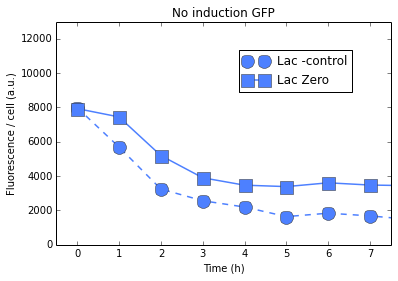

In [11]:
for P in Pidxs:
    pl.plot(np.mean( NormdOD[P+'-control'], axis=1), 
            'o--', lw=1.5, markersize=13., color=Pcolors[P], markeredgecolor=(0.2,0.2,0.2), label=P+' -control')
    
    pl.plot(np.mean( NormdOD[P+'ZeroC'], axis=1), 
            's-', lw=1.5, markersize=13., color=Pcolors[P], markeredgecolor=(0.2,0.2,0.2), label=P+' Zero')

pl.title('No induction GFP')
pl.xlabel('Time (h)')
pl.xlim(-0.5,7.5)
pl.ylabel('Fluorescence / cell (a.u.)')
pl.ylim(0,13000)
pl.legend(bbox_to_anchor=(0.9, 0.9))
pl.show()

### Preparing and normalizing promoter data

In [24]:
def activitySummary(P, Concs, ax1yi = [0.7,1.3], ax2yi = [0.7,1.1], ax3yi = [0.8, 1.4]):
    
    f, (ax1, ax2) = pl.subplots(1, 2, figsize=(10,3.5))
    
    ZeroLevel = np.mean( NormdOD[P+'ZeroC'] , axis=1)
    mds = [1]
    stds = [0]
    
    for j in Concs:
        Cj_ts = np.mean( NormdOD[P+j] / NormdOD[P+'ZeroC'], axis=1 ) 
        ax1.plot( Cj_ts, 'o-', lw=1.5, markersize=13., label=j)
        mds.append( Cj_ts.mean() )
        stds.append( Cj_ts.std() )
    
    ax1.set_title('GFP')
    ax1.set_xlim(-1,9)
    ax1.set_xlabel('Time (h)')
    ax1.set_ylim(ax1yi)
    ax1.set_ylabel('Rel.  Fluorescence (u.a.)')
    ax1.legend(bbox_to_anchor=(1.1, 0.))
    
    ax2.set_title('GFP')
    ax2.bar(np.array(range(0,len(mds))) - 0.4, mds, 0.8, yerr=stds, color=(0.5,0.7,1.0))
    ax2.set_xlim(-1.,6)
    pl.xticks(np.array(range(0,len(mds))), ['Zero'] + Concs)
    ax2.set_xlabel('Concentration (label)')
    ax2.set_ylim(ax3yi)
    ax2.set_ylabel('')
    
    pl.show()
    
    return

Lac


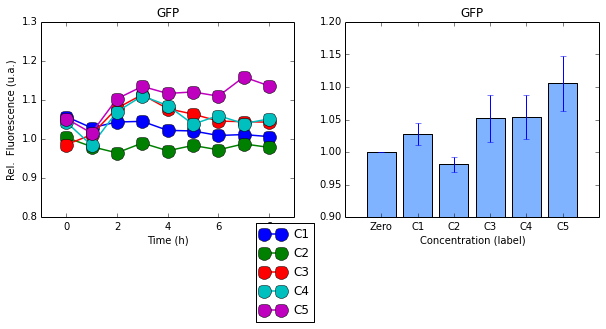

In [25]:
print 'Lac'
activitySummary('Lac', ['C1','C2','C3','C4','C5'], ax1yi = [0.8,1.3], ax3yi = [0.9, 1.2])